In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
cd 'drive/My Drive/Siamese/Encoder/Time'

/content/drive/My Drive/Siamese/Encoder/Time


In [3]:
import sys
sys.path.insert(0, '../../Data')
sys.path.insert(0, '../..')
sys.path.insert(0, '..')

In [4]:
!pip install torchvision==0.5.0
!pip install torchaudio==0.4.0
#!pip install torch==1.4.0

In [5]:
import torch
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda


In [6]:
import os
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.transforms import Compose

from tqdm import tqdm

In [7]:
DATASET_PATH = '/content/drive/My Drive/DataSet'
EPOCH_NUM = 30

torch.backends.cudnn.deterministic = True
B = 32

WEIGHT_DECAY = 5e-4
LR_INIT = 1e-2
LR_LAST = 1e-4
# lr scheduler parameter
gamma = 10 ** (np.log10(LR_LAST / LR_INIT) / (EPOCH_NUM - 1))
MOMENTUM = 0.9
NUM_WORKERS = 4

NUM_CLASSES = 200

In [8]:
from IdentificationDataset import IdentificationDataset
from IdentificationDataset import ReturnType

from Normalize import Normalize
from ToTensor import ToTensor

DATASET_PATH = '/content/drive/My Drive/DataSet'

transforms = Compose([
    Normalize(),
    ToTensor()
])

trainset = IdentificationDataset(DATASET_PATH, 
                                 NUM_CLASSES,
                                 train=True, 
                                 transform=transforms,
                                 lenght=2,
                                 return_type=ReturnType.ENCODER)
trainsetloader = torch.utils.data.DataLoader(trainset, 
                                             batch_size=B, 
                                             num_workers=NUM_WORKERS, 
                                             shuffle=True)

testset = IdentificationDataset(DATASET_PATH, 
                                10,
                                train=False, 
                                transform=transforms,
                                lenght=2,
                                return_type=ReturnType.ENCODER)
testsetloader = torch.utils.data.DataLoader(testset, 
                                            batch_size=1, 
                                            num_workers=NUM_WORKERS)

print("lenght train loader ", len(trainsetloader))
print("lenght test loader ", len(testsetloader))


sample lenght  2
sample lenght  2
lenght train loader  742
lenght test loader  1151


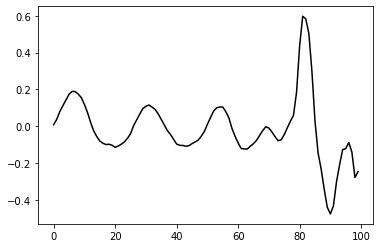

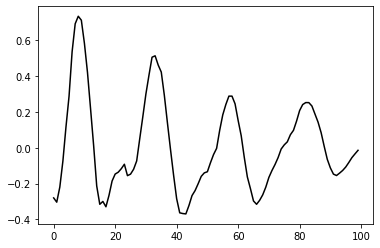

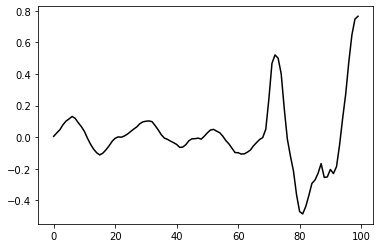

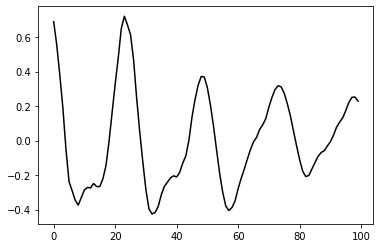

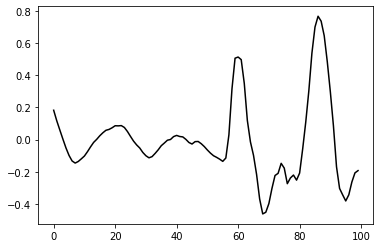

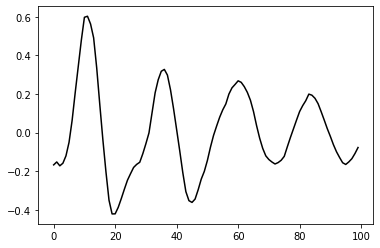

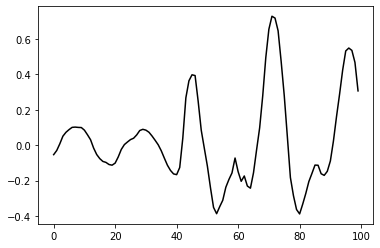

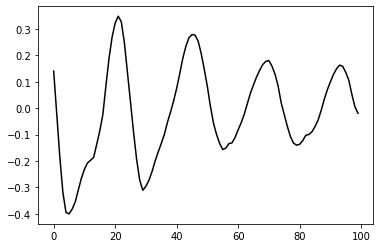

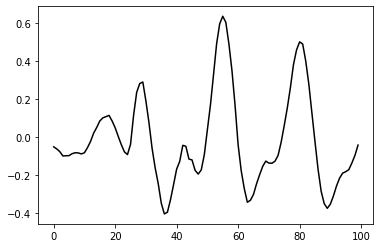

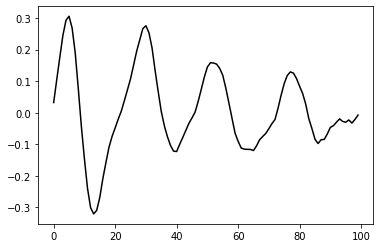

In [9]:
import matplotlib.pyplot as plt

for (_, sample, _, _, _) in trainsetloader:
  break
sample = sample[0]
frag = 100
for start in range(2000, 3000, 100):
  plt.figure()
  plt.plot([i for i in range(frag)], sample[start:start+frag], label='sample', color='black')
  plt.show()

In [10]:
from Time import Time 

# Define default device, we should use the GPU (cuda) if available
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)
net = Time(avg=False)

net.to(DEVICE)

cuda


Time(
  (block0): Conv1DBlock(
    (conv): Conv1d(1, 32, kernel_size=(9,), stride=(2,))
    (acti): ReLU()
    (bn): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (maxpool): MaxPool1d(kernel_size=9, stride=8, padding=0, dilation=1, ceil_mode=False)
  )
  (block1): Conv1DBlock(
    (conv): Conv1d(32, 256, kernel_size=(9,), stride=(2,))
    (acti): ReLU()
    (bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (maxpool): MaxPool1d(kernel_size=9, stride=4, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Conv1DBlock(
    (conv): Conv1d(256, 256, kernel_size=(9,), stride=(2,))
    (acti): ReLU()
    (bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (maxpool): MaxPool1d(kernel_size=9, stride=4, padding=0, dilation=1, ceil_mode=False)
  )
  (block3): Conv1DBlock(
    (conv1): Conv1d(256, 64, kernel_size=(1,), stride=(1,))
    (conv2): Conv1d(256, 192, kernel_size=(3,),

In [11]:
import numpy as np
optimizer = optim.SGD(net.parameters(), LR_INIT, MOMENTUM, weight_decay=WEIGHT_DECAY)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=gamma)

max_accuracy = 0
test_accuracy = []
train_accuracy = []

train_loss = 0
train_losses = []
test_loss = 0
test_losses = []

for epoch_num in range(EPOCH_NUM):
    print("*** Epoch ", epoch_num, " ***")
    lr_scheduler.step()
    
    # train
    print("*** Train ***")
    net.train()

    accuracy = 0
    nb_test = 0
    
    for iter_num, (_, a, p, n_label, n) in tqdm(enumerate(trainsetloader)):
        optimizer.zero_grad()
        a, p, n = a.to(DEVICE), p.to(DEVICE), n.to(DEVICE)

        loss, results, a, p, n = net(a, p , n)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

        for result in results:
          nb_test += 1
          if result == True:
            accuracy += 1

    train_accuracy.append(accuracy/nb_test)
    train_loss /= len(trainsetloader)
    train_losses.append(train_loss)
        
    # test
    net.eval()
    print("*** Test ***")
    
    accuracy = 0
    nb_test = 0
    loss = 0

    for iter_num, (label, a, p, n_label, n) in tqdm(enumerate(testsetloader)):
        a, p, n = a.to(DEVICE), p.to(DEVICE), n.to(DEVICE)
        loss, result, a, p, n = net(a, p , n)

        # Calculate loss
        test_loss += loss.item()

        nb_test += 1
        if result == True:
          accuracy += 1
    
    accuracy /= nb_test
    test_accuracy.append(accuracy)
    print("accuracy = ", accuracy)
    if accuracy > max_accuracy:
      net.store_encoder(size=2)
      max_accuracy = accuracy
    test_loss /= len(testsetloader)
    test_losses.append(test_loss)    


*** Epoch  0  ***
*** Train ***


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:122: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
742it [01:22,  8.95it/s]

*** Test ***



1151it [00:13, 82.36it/s]


accuracy =  0.6993918331885317
*** Epoch  1  ***
*** Train ***


742it [01:22,  8.95it/s]

*** Test ***



1151it [00:14, 82.10it/s]

accuracy =  0.6959165942658557
*** Epoch  2  ***
*** Train ***



742it [01:22,  8.98it/s]

*** Test ***



1151it [00:14, 81.84it/s]

accuracy =  0.7080799304952216
*** Epoch  3  ***
*** Train ***



742it [01:22,  8.96it/s]

*** Test ***



1151it [00:14, 80.09it/s]

accuracy =  0.7289313640312771
*** Epoch  4  ***
*** Train ***



742it [01:22,  8.98it/s]

*** Test ***



1151it [00:13, 83.01it/s]

accuracy =  0.7185056472632494
*** Epoch  5  ***
*** Train ***



742it [01:22,  9.00it/s]

*** Test ***



1151it [00:13, 83.25it/s]

accuracy =  0.7471763683753258
*** Epoch  6  ***
*** Train ***



742it [01:22,  8.96it/s]

*** Test ***



1151it [00:13, 83.46it/s]

accuracy =  0.7515204170286707
*** Epoch  7  ***
*** Train ***



742it [01:23,  8.93it/s]

*** Test ***



1151it [00:13, 83.29it/s]


accuracy =  0.7532580364900087
*** Epoch  8  ***
*** Train ***


742it [01:22,  8.99it/s]

*** Test ***



1151it [00:13, 83.56it/s]

accuracy =  0.7437011294526499
*** Epoch  9  ***
*** Train ***



742it [01:22,  8.97it/s]

*** Test ***



1151it [00:13, 82.75it/s]


accuracy =  0.7723718505647263
*** Epoch  10  ***
*** Train ***


742it [01:23,  8.94it/s]

*** Test ***



1151it [00:13, 83.59it/s]

accuracy =  0.7671589921807124
*** Epoch  11  ***
*** Train ***



742it [01:22,  9.02it/s]

*** Test ***



1151it [00:14, 82.06it/s]

accuracy =  0.7645525629887054
*** Epoch  12  ***
*** Train ***



742it [01:22,  9.00it/s]

*** Test ***



1151it [00:13, 82.65it/s]

accuracy =  0.7619461337966985
*** Epoch  13  ***
*** Train ***



742it [01:23,  8.91it/s]

*** Test ***



1151it [00:14, 80.64it/s]

accuracy =  0.7628149435273676
*** Epoch  14  ***
*** Train ***



742it [01:29,  8.27it/s]

*** Test ***



1151it [00:14, 79.20it/s]

accuracy =  0.7645525629887054
*** Epoch  15  ***
*** Train ***



742it [01:24,  8.80it/s]

*** Test ***



1151it [00:14, 80.39it/s]

accuracy =  0.7584708948740226
*** Epoch  16  ***
*** Train ***



742it [01:24,  8.75it/s]

*** Test ***



1151it [00:14, 81.37it/s]


accuracy =  0.792354474370113
*** Epoch  17  ***
*** Train ***


742it [01:23,  8.87it/s]

*** Test ***



1151it [00:14, 81.81it/s]

accuracy =  0.7810599478714162
*** Epoch  18  ***
*** Train ***



742it [01:23,  8.89it/s]

*** Test ***



1151it [00:14, 81.36it/s]

accuracy =  0.7810599478714162
*** Epoch  19  ***
*** Train ***



742it [01:23,  8.85it/s]

*** Test ***



1151it [00:13, 82.24it/s]

accuracy =  0.7775847089487402
*** Epoch  20  ***
*** Train ***



742it [01:23,  8.86it/s]

*** Test ***



1151it [00:14, 81.25it/s]

accuracy =  0.7767158992180713
*** Epoch  21  ***
*** Train ***



742it [01:23,  8.94it/s]

*** Test ***



1151it [00:13, 82.53it/s]

accuracy =  0.7767158992180713
*** Epoch  22  ***
*** Train ***



742it [01:23,  8.89it/s]

*** Test ***



1151it [00:14, 77.65it/s]

accuracy =  0.7680278019113814
*** Epoch  23  ***
*** Train ***



742it [01:23,  8.87it/s]

*** Test ***



1151it [00:14, 78.81it/s]


accuracy =  0.7801911381407471
*** Epoch  24  ***
*** Train ***


742it [01:24,  8.80it/s]

*** Test ***



1151it [00:14, 79.73it/s]

accuracy =  0.7810599478714162
*** Epoch  25  ***
*** Train ***



742it [01:24,  8.76it/s]

*** Test ***



1151it [00:13, 82.59it/s]

accuracy =  0.7767158992180713
*** Epoch  26  ***
*** Train ***



742it [01:24,  8.83it/s]

*** Test ***



1151it [00:13, 82.27it/s]

accuracy =  0.7775847089487402
*** Epoch  27  ***
*** Train ***



742it [01:22,  8.96it/s]

*** Test ***



1151it [00:14, 82.07it/s]

accuracy =  0.7958297132927888
*** Epoch  28  ***
*** Train ***



742it [01:23,  8.93it/s]

*** Test ***



1151it [00:14, 82.02it/s]

accuracy =  0.7784535186794093
*** Epoch  29  ***
*** Train ***



742it [01:24,  8.74it/s]

*** Test ***



1151it [00:14, 80.04it/s]

accuracy =  0.7801911381407471


train accuracy end:0.892 max:0.894
test accuracy end:0.78 max:0.796


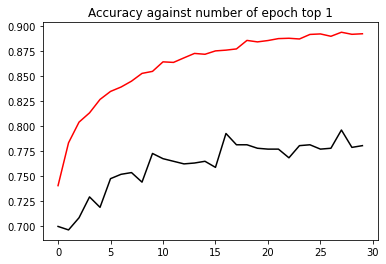

In [12]:
import matplotlib.pyplot as plt

plt.title("Accuracy against number of epoch top 1")
plt.plot([i for i in range(EPOCH_NUM)], train_accuracy , label='test 1', color='red')
plt.plot([i for i in range(EPOCH_NUM)], test_accuracy , label='test 1', color='black')
print('train accuracy end:{} max:{}'
.format(round(train_accuracy[EPOCH_NUM-1], 3), round(np.max(train_accuracy), 3)))
print('test accuracy end:{} max:{}'
.format(round(test_accuracy[EPOCH_NUM-1], 3), round(np.max(test_accuracy), 3)))


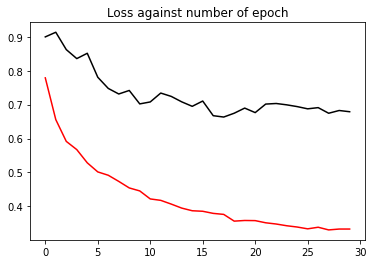

In [13]:
plt.title("Loss against number of epoch")
plt.plot([i for i in range(EPOCH_NUM)], train_losses , label='Train loss', color='red')
plt.plot([i for i in range(EPOCH_NUM)], test_losses , label='Test loss', color='black')
